In [2]:
import pickle
import pandas as pd
import numpy as np
import os
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu,softmax
from sklearn import model_selection, naive_bayes, svm, ensemble
#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix


# Intro


In [3]:
#get labels
file = open('/content/drive/MyDrive/data/australia_tweets6.txt')
csvreader = pd.read_csv(file, sep='<delimiter>')
print(csvreader.groupby(["sentiment"]).count())
csvreader.loc[csvreader['sentiment'] == 'very positive', 'sentiment'] = 'positive'
csvreader.loc[csvreader['sentiment'] == 'very negative', 'sentiment'] = 'negative'
print(csvreader.groupby(["sentiment"]).count())
y = csvreader['sentiment']

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


                  tweeter_id   text
sentiment                          
negative               82423  82423
neutral or mixed       24334  24334
positive               36263  36263
very negative           5396   5396
very positive            770    770
                  tweeter_id   text
sentiment                          
negative               87819  87819
neutral or mixed       24334  24334
positive               37033  37033


In [4]:
bert_embeddings_pickle_path = "/content/drive/MyDrive/data/bertEmbeddings/DistilBertTransfer"
embeddings = []
labels = []

for root, dirs, files in os.walk(bert_embeddings_pickle_path, topdown=False):
  for name in files:
    path = os.path.join(root, name)
    bert_pickle = pickle.load(open(path, "rb"))
    #print(len(bert_pickle['embeddings']))
    embeddings.extend(bert_pickle['embeddings'])
    start = bert_pickle['start']
    end = bert_pickle['end']
    l = y.values[start:end]
    labels.extend(l)
    


In [5]:
#labels = y.values[start:end] #np.array
embeddings = np.asarray(embeddings) #np.array
print(len(labels)) #149168
print(len(embeddings)) #149168

149186
149186


In [6]:
#use only one portion of dataset 
embeddings_copy = embeddings.copy()
labels_copy = embeddings.copy()
embeddings = embeddings[0:16384]
labels = labels[0:16384]

In [6]:
#encoding labels [0,0,1]
encoder = OneHotEncoder()
print(len(labels))
labels_df = pd.DataFrame(labels)
encoded_labels = encoder.fit_transform(labels_df.values.reshape(-1, 1)).toarray()
print(encoded_labels[0])

#train test split 0.3
train_x, test_x, train_y, test_y = model_selection.train_test_split(embeddings, encoded_labels, stratify = labels, test_size=0.3, random_state=100)

#label encoding

16384
[0. 0. 1.]


In [7]:
def data_generator(embeddings, labels, batch_size, epochs, type): #embeddings, labels type list
  epoch_steps = int(len(embeddings)/batch_size)
  steps = epoch_steps * epochs
  iterration = 0
  for i in range(steps):
    iterration = i%epoch_steps #step_in_epoch
    start = iterration*batch_size
    end = start + batch_size - 1 
    x = np.array(embeddings[start:end])
    y = np.array(labels[start:end])
    #print("yielding "+type)
    yield (x,y)


In [8]:
import matplotlib.pyplot as plt
def print_and_plot_history(history):
  print('val_acc: ',max(history.history['val_categorical_accuracy']))
  print('val_loss: ',min(history.history['val_loss']))
  print('train_acc: ',max(history.history['categorical_accuracy']))
  print('train_loss: ',min(history.history['loss']))
  print("train/val loss ratio: ", min(history.history['loss'])/min(history.history['val_loss']))

  plt.semilogy(history.history['loss'])
  plt.semilogy(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

First, we create a large model that is fitting at least the training set. We choose appropriate model and regularize it to gain validation accuracy by giving up some training accuracy.


# Model V1
256, 512, 600, 3 (94,3%)

In [ ]:
modelv1 = Sequential()
modelv1.add(Dense(256, input_dim=768, activation='relu')) #768 for CLS token
modelv1.add(Dense(512, activation='relu'))
modelv1.add(Dense(600, activation='relu'))
modelv1.add(Dense(3, activation='softmax'))

batch_size = 32
epochs = 40
train_generator = data_generator(train_x, train_y, batch_size, epochs, "train")
validation_generator = data_generator(test_x, test_y, batch_size, epochs, "validation")

from keras.callbacks import ModelCheckpoint, EarlyStopping
directory_path = '/content/drive/MyDrive/models'
filepath = directory_path + '/bert_transfer_mlpv1/'+str(epochs)+'_epochs_'+str(batch_size)+"_batch_"

checkpointer = ModelCheckpoint(filepath=filepath+"{epoch:02d}-{categorical_accuracy:.3f}."+"hdf5",
                               verbose=1,
                               save_best_only=True,  
                               monitor='categorical_accuracy',
                               mode = 'max')
earlystopper = EarlyStopping(monitor='categorical_accuracy',
                              patience=10,
                              mode='max',
                              restore_best_weights=True)

modelv1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

train_steps = int(len(train_x)/batch_size)
val_steps = int(len(test_x)/batch_size)
historyv1 = modelv1.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [checkpointer], #early stopping
                    validation_data = validation_generator,
                    validation_steps = val_steps
                    )

Epoch 1/40
355/358 [============================>.] - ETA: 0s - loss: 0.7352 - categorical_accuracy: 0.7081
Epoch 1: categorical_accuracy improved from -inf to 0.70842, saving model to /content/drive/MyDrive/models/bert_transfer_mlpv1/40_epochs_32_batch_01-0.708.hdf5
358/358 [==============================] - 5s 13ms/step - loss: 0.7349 - categorical_accuracy: 0.7084 - val_loss: 0.7206 - val_categorical_accuracy: 0.7211
Epoch 2/40
353/358 [============================>.] - ETA: 0s - loss: 0.6757 - categorical_accuracy: 0.7280
Epoch 2: categorical_accuracy improved from 0.70842 to 0.72779, saving model to /content/drive/MyDrive/models/bert_transfer_mlpv1/40_epochs_32_batch_02-0.728.hdf5
358/358 [==============================] - 4s 12ms/step - loss: 0.6762 - categorical_accuracy: 0.7278 - val_loss: 0.7473 - val_categorical_accuracy: 0.7179
Epoch 3/40
353/358 [============================>.] - ETA: 0s - loss: 0.6545 - categorical_accuracy: 0.7355
Epoch 3: categorical_accuracy improved fr

val_acc:  0.7343453764915466
val_loss:  0.7042565941810608
train_acc:  0.9431428909301758
train_loss:  0.15217994153499603
train/val loss ratio:  0.21608593060027684


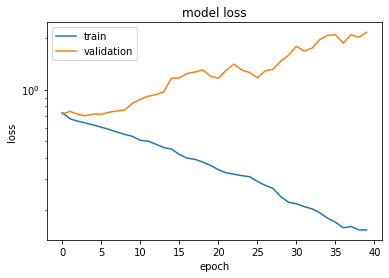

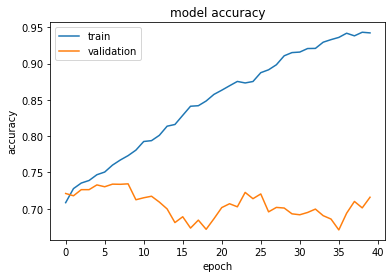

In [ ]:
print_and_plot_history(historyv1)

# Model V2
256, 512, 512, 512, 600, 3 (91,3%)

Epoch 1/40
356/358 [============================>.] - ETA: 0s - loss: 0.7391 - categorical_accuracy: 0.7050
Epoch 1: categorical_accuracy improved from -inf to 0.70472, saving model to /content/drive/MyDrive/models/bert_transfer_mlpv2/40_epochs_32_batch_01-0.705.hdf5
358/358 [==============================] - 8s 19ms/step - loss: 0.7400 - categorical_accuracy: 0.7047 - val_loss: 0.7287 - val_categorical_accuracy: 0.7196
Epoch 2/40
357/358 [============================>.] - ETA: 0s - loss: 0.6815 - categorical_accuracy: 0.7268
Epoch 2: categorical_accuracy improved from 0.70472 to 0.72662, saving model to /content/drive/MyDrive/models/bert_transfer_mlpv2/40_epochs_32_batch_02-0.727.hdf5
358/358 [==============================] - 7s 20ms/step - loss: 0.6824 - categorical_accuracy: 0.7266 - val_loss: 0.7212 - val_categorical_accuracy: 0.7259
Epoch 3/40
357/358 [============================>.] - ETA: 0s - loss: 0.6658 - categorical_accuracy: 0.7314
Epoch 3: categorical_accuracy improved fr

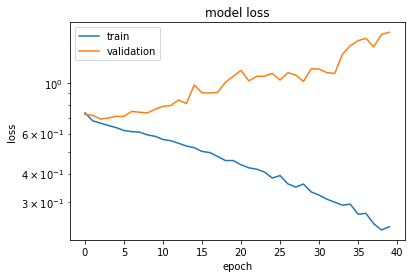

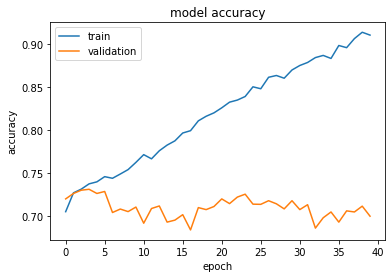

In [ ]:
modelv2 = Sequential()
modelv2.add(Dense(256, input_dim=768, activation='relu')) #768 for CLS token
modelv2.add(Dense(512, activation='relu'))
modelv2.add(Dense(512, activation='relu'))
modelv2.add(Dense(512, activation='relu'))
modelv2.add(Dense(600, activation='relu'))
modelv2.add(Dense(3, activation='softmax'))

batch_size = 32
epochs = 40
train_generator = data_generator(train_x, train_y, batch_size, epochs, "train")
validation_generator = data_generator(test_x, test_y, batch_size, epochs, "validation")

from keras.callbacks import ModelCheckpoint, EarlyStopping
directory_path = '/content/drive/MyDrive/models'
filepath = directory_path + '/bert_transfer_mlpv2/'+str(epochs)+'_epochs_'+str(batch_size)+"_batch_"

checkpointer = ModelCheckpoint(filepath=filepath+"{epoch:02d}-{categorical_accuracy:.3f}."+"hdf5",
                               verbose=1,
                               save_best_only=True,  
                               monitor='categorical_accuracy',
                               mode = 'max')
earlystopper = EarlyStopping(monitor='categorical_accuracy',
                              patience=10,
                              mode='max',
                              restore_best_weights=True)
modelv2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

train_steps = int(len(train_x)/batch_size)
val_steps = int(len(test_x)/batch_size)
historyv2 = modelv2.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [checkpointer], #early stopping
                    validation_data = validation_generator,
                    validation_steps = val_steps
                    )

val_acc:  0.7307611107826233
val_loss:  0.6951198577880859
train_acc:  0.9133177399635315
train_loss:  0.22642579674720764
train/val loss ratio:  0.325736337712619


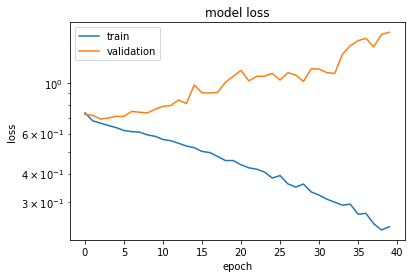

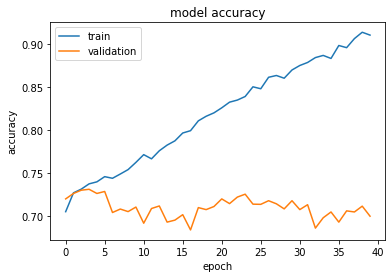

In [ ]:
print_and_plot_history(historyv2)

# Model V3
256, 600, 3 (92,4%)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu,softmax

modelv3 = Sequential()
modelv3.add(Dense(256, input_dim=768, activation='relu')) #768 for CLS token
modelv3.add(Dense(600, activation='relu'))
modelv3.add(Dense(3, activation='softmax'))

batch_size = 32
epochs = 40
train_generator = data_generator(train_x, train_y, batch_size, epochs, "train")
validation_generator = data_generator(test_x, test_y, batch_size, epochs, "validation")

from keras.callbacks import ModelCheckpoint, EarlyStopping
directory_path = '/content/drive/MyDrive/models'
filepath = directory_path + '/bert_transfer_mlpv3/'+str(epochs)+'_epochs_'+str(batch_size)+"_batch_"

checkpointer = ModelCheckpoint(filepath=filepath+"{epoch:02d}-{categorical_accuracy:.3f}."+"hdf5",
                               verbose=1,
                               save_best_only=True,  
                               monitor='categorical_accuracy',
                               mode = 'max')
earlystopper = EarlyStopping(monitor='categorical_accuracy',
                              patience=10,
                              mode='max',
                              restore_best_weights=True)
modelv3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

train_steps = int(len(train_x)/batch_size)
val_steps = int(len(test_x)/batch_size)
historyv3 = modelv3.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [checkpointer], #early stopping
                    validation_data = validation_generator,
                    validation_steps = val_steps
                    )

Epoch 1/40
355/358 [============================>.] - ETA: 0s - loss: 0.7283 - categorical_accuracy: 0.7082
Epoch 1: categorical_accuracy improved from -inf to 0.70851, saving model to /content/drive/MyDrive/models/bert_transfer_mlpv3/40_epochs_32_batch_01-0.709.hdf5
358/358 [==============================] - 4s 11ms/step - loss: 0.7281 - categorical_accuracy: 0.7085 - val_loss: 0.7347 - val_categorical_accuracy: 0.7141
Epoch 2/40
358/358 [==============================] - ETA: 0s - loss: 0.6719 - categorical_accuracy: 0.7276
Epoch 2: categorical_accuracy improved from 0.70851 to 0.72761, saving model to /content/drive/MyDrive/models/bert_transfer_mlpv3/40_epochs_32_batch_02-0.728.hdf5
358/358 [==============================] - 3s 8ms/step - loss: 0.6719 - categorical_accuracy: 0.7276 - val_loss: 0.6923 - val_categorical_accuracy: 0.7257
Epoch 3/40
356/358 [============================>.] - ETA: 0s - loss: 0.6483 - categorical_accuracy: 0.7362
Epoch 3: categorical_accuracy improved fro

val_acc:  0.7322369813919067
val_loss:  0.6843181252479553
train_acc:  0.9236799478530884
train_loss:  0.20548488199710846
train/val loss ratio:  0.3002768367747869


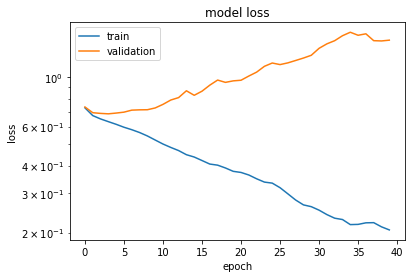

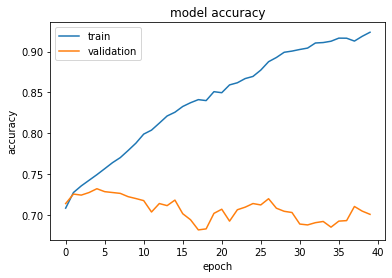

In [ ]:
print_and_plot_history(historyv3)

# Model V4
256, 600, 600, 3 (95,9%)

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu,softmax

modelv4 = Sequential()
modelv4.add(Dense(256, input_dim=768, activation='relu')) #768 for CLS token
modelv4.add(Dense(600, activation='relu'))
modelv4.add(Dense(600, activation='relu'))
modelv4.add(Dense(3, activation='softmax'))

batch_size = 32
epochs = 40
train_generator = data_generator(train_x, train_y, batch_size, epochs, "train")
validation_generator = data_generator(test_x, test_y, batch_size, epochs, "validation")

from keras.callbacks import ModelCheckpoint, EarlyStopping
directory_path = '/content/drive/MyDrive/models'
filepath = directory_path + '/bert_transfer_mlpv4/'+str(epochs)+'_epochs_'+str(batch_size)+"_batch_"

checkpointer = ModelCheckpoint(filepath=filepath+"{epoch:02d}-{categorical_accuracy:.3f}."+"hdf5",
                               verbose=1,
                               save_best_only=True,  
                               monitor='categorical_accuracy',
                               mode = 'max')
earlystopper = EarlyStopping(monitor='categorical_accuracy',
                              patience=10,
                              mode='max',
                              restore_best_weights=True)
modelv4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

train_steps = int(len(train_x)/batch_size)
val_steps = int(len(test_x)/batch_size)
historyv4 = modelv4.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [checkpointer], #early stopping
                    validation_data = validation_generator,
                    validation_steps = val_steps
                    )

Epoch 1/40
357/358 [============================>.] - ETA: 0s - loss: 0.7344 - categorical_accuracy: 0.7073
Epoch 1: categorical_accuracy improved from -inf to 0.70715, saving model to /content/drive/MyDrive/models/bert_transfer_mlpv4/40_epochs_32_batch_01-0.707.hdf5
358/358 [==============================] - 7s 16ms/step - loss: 0.7350 - categorical_accuracy: 0.7072 - val_loss: 0.7291 - val_categorical_accuracy: 0.7225
Epoch 2/40
357/358 [============================>.] - ETA: 0s - loss: 0.6759 - categorical_accuracy: 0.7279
Epoch 2: categorical_accuracy improved from 0.70715 to 0.72770, saving model to /content/drive/MyDrive/models/bert_transfer_mlpv4/40_epochs_32_batch_02-0.728.hdf5
358/358 [==============================] - 5s 13ms/step - loss: 0.6766 - categorical_accuracy: 0.7277 - val_loss: 0.7081 - val_categorical_accuracy: 0.7257
Epoch 3/40
358/358 [==============================] - ETA: 0s - loss: 0.6548 - categorical_accuracy: 0.7335
Epoch 3: categorical_accuracy improved fr

val_acc:  0.7290744185447693
val_loss:  0.7025691270828247
train_acc:  0.9589115381240845
train_loss:  0.1119665876030922
train/val loss ratio:  0.15936736085742156


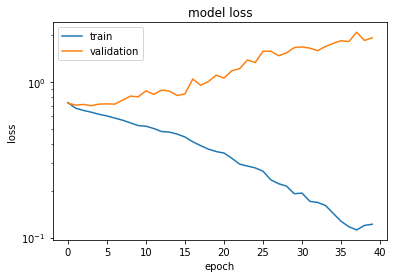

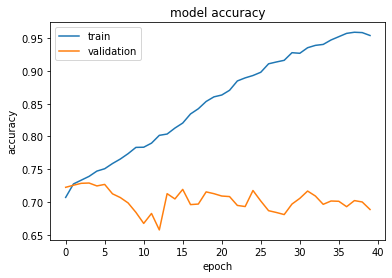

In [11]:
print_and_plot_history(historyv4)

# Model V5
256, 600, 600, 600, 3 (94,2%)

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu,softmax

modelv5 = Sequential()
modelv5.add(Dense(256, input_dim=768, activation='relu')) #768 for CLS token
modelv5.add(Dense(600, activation='relu'))
modelv5.add(Dense(600, activation='relu'))
modelv5.add(Dense(600, activation='relu'))
modelv5.add(Dense(3, activation='softmax'))

batch_size = 32
epochs = 40
train_generator = data_generator(train_x, train_y, batch_size, epochs, "train")
validation_generator = data_generator(test_x, test_y, batch_size, epochs, "validation")

from keras.callbacks import ModelCheckpoint, EarlyStopping
directory_path = '/content/drive/MyDrive/models'
filepath = directory_path + '/bert_transfer_mlpv5/'+str(epochs)+'_epochs_'+str(batch_size)+"_batch_"

checkpointer = ModelCheckpoint(filepath=filepath+"{epoch:02d}-{categorical_accuracy:.3f}."+"hdf5",
                               verbose=1,
                               save_best_only=True,  
                               monitor='categorical_accuracy',
                               mode = 'max')
earlystopper = EarlyStopping(monitor='categorical_accuracy',
                              patience=10,
                              mode='max',
                              restore_best_weights=True)
modelv5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

train_steps = int(len(train_x)/batch_size)
val_steps = int(len(test_x)/batch_size)
historyv5 = modelv5.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    callbacks = [checkpointer], #early stopping
                    validation_data = validation_generator,
                    validation_steps = val_steps
                    )

Epoch 1/40
358/358 [==============================] - ETA: 0s - loss: 0.7402 - categorical_accuracy: 0.7066
Epoch 1: categorical_accuracy improved from -inf to 0.70661, saving model to /content/drive/MyDrive/models/bert_transfer_mlpv5/40_epochs_32_batch_01-0.707.hdf5
358/358 [==============================] - 7s 17ms/step - loss: 0.7402 - categorical_accuracy: 0.7066 - val_loss: 0.7251 - val_categorical_accuracy: 0.7206
Epoch 2/40
358/358 [==============================] - ETA: 0s - loss: 0.6818 - categorical_accuracy: 0.7285
Epoch 2: categorical_accuracy improved from 0.70661 to 0.72851, saving model to /content/drive/MyDrive/models/bert_transfer_mlpv5/40_epochs_32_batch_02-0.729.hdf5
358/358 [==============================] - 6s 18ms/step - loss: 0.6818 - categorical_accuracy: 0.7285 - val_loss: 0.7275 - val_categorical_accuracy: 0.7238
Epoch 3/40
357/358 [============================>.] - ETA: 0s - loss: 0.6628 - categorical_accuracy: 0.7316
Epoch 3: categorical_accuracy improved fr

val_acc:  0.7305502891540527
val_loss:  0.6942024230957031
train_acc:  0.9418814182281494
train_loss:  0.15835705399513245
train/val loss ratio:  0.2281136578131783


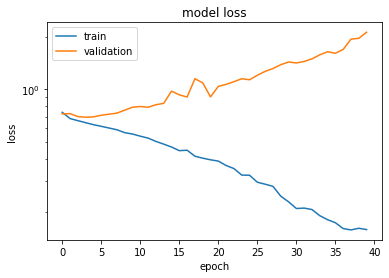

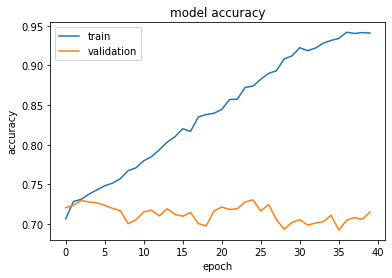

In [13]:
print_and_plot_history(historyv5)

# Regularization
Models to be regularized: V1, V4, V5


*   Train on more data
*   Add batch normalization
*   Add dropout (no batch norm.)
*   Add early stopping
*   Weight decaying





